# CNN Model for Predicting Age from 12-lead ECG signals

In [3]:
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
tf.config.list_physical_devices('GPU') # Verify you have a GPU available. Not required

[]

### Loading raw Data into Mutable Dataframes

In [4]:
with tf.device('/CPU:0'):
    ### Loading raw data into mutable Datframes
    ptb = pd.read_csv('../data/ptbxl_database.csv')
    def load_raw_data(df, sampling_rate, path):
        if(sampling_rate == 100):
            data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
        else:
            data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
        data = np.array([signal for signal, meta in data])
        return data
    
    sampling_rate=100
    # load and convert annotation data
    Y = pd.read_csv('../data/ptbxl_database.csv', index_col='ecg_id')
    Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

    # Load raw signal data
    X = load_raw_data(Y, 100, '../data/')

    # Load scp_statements.csv for diagnostic aggregation
    agg_df = pd.read_csv('../data/scp_statements.csv', index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]

    def aggregate_diagnostic(y_dic):
        tmp = []
        for key in y_dic.keys():
            if key in agg_df.index:
                tmp.append(agg_df.loc[key].diagnostic_class)
        return list(set(tmp))


    # Apply diagnostic superclass
    Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)



## Data Augmentation

### Quality Filter

In [ ]:
# X = X[(Y.validated_by_human == True)]
# Y = Y[(Y.validated_by_human == True)]

### Band Pass Filter

In [14]:
import numpy as np
from scipy import signal
with tf.device('/CPU:0'):
    # Define the filter parameters
    fs = 100  # Sampling frequency (Hz)
    lowcut = 0.5  # Lower cutoff frequency (Hz)
    highcut = 40.0  # Higher cutoff frequency (Hz)
    filter_order = 4  # Filter order

    def bandpass(X, fs, lowcut, highcut, filter_order):
        # Apply bandpass filter to each channel
        filtered_data = np.zeros_like(X)
        for i in range(X.shape[2]):
            for j in range(X.shape[0]):
                b, a = signal.butter(filter_order, [lowcut, highcut], fs=fs, btype='band', output='ba')
                filtered_data[j, :, i] = signal.filtfilt(b, a, X[j, :, i])

        # Print the shape of the filtered data
        return filtered_data

### Baseline Drift and Normalization

In [15]:
with tf.device('/CPU:0'):
    def normalize(X, shape = False):
        # Compute mean and standard deviation along axis 1 and 2
        X_mean = np.mean(X)
        X_std = np.std(X)

        if(shape):
            print(X.shape)
        # Normalize data by subtracting mean and dividing by standard deviation
        return ((X - X_mean) / X_std)


    bld = 0.5
    def baseline_drift(X, baseline, range = 0):
        bld_range = (baseline-range, baseline+range)
        random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape)
        return X + random_shifts

### DA Applyer

In [16]:
with tf.device('/CPU:0'):
    def da_apply(X, functions, shape = False):
        X_final = X.copy()

        # Applys DA Augments in specified order
        for func_dict in functions:
            func = func_dict['func']
            if(func_dict['params'] == None):
                X_final = func(X_final)     
            else:
                params = func_dict['params']
                X_final = func(X_final, *params)  

        if(shape == True):
            print(X_final.shape)

        return X_final

    #func_dict = [{'func': normalize, 'params': [None]}]

    #func_dict = [{'func': baseline_drift, 'params': [0,0.05]}]

    # func_dict =[{'func': normalize, 'params': [None]},
    #             {'func': bandpass, 'params': [100, 0.5, 10, 3]}, # 100, 0.5, 10, 3
    #             {'func': baseline_drift, 'params': [0,0.075]}]


    func_dict =[{'func': bandpass, 'params': [100, 0.5, 15, 3]}, # 100, 0.5, 10, 3
                {'func': normalize, 'params': [None]},
                {'func': baseline_drift, 'params': [0,0.075]}]

    X_final = da_apply(X, func_dict) # If you want to experiment with data shape more, use a smaller data size. Subset X

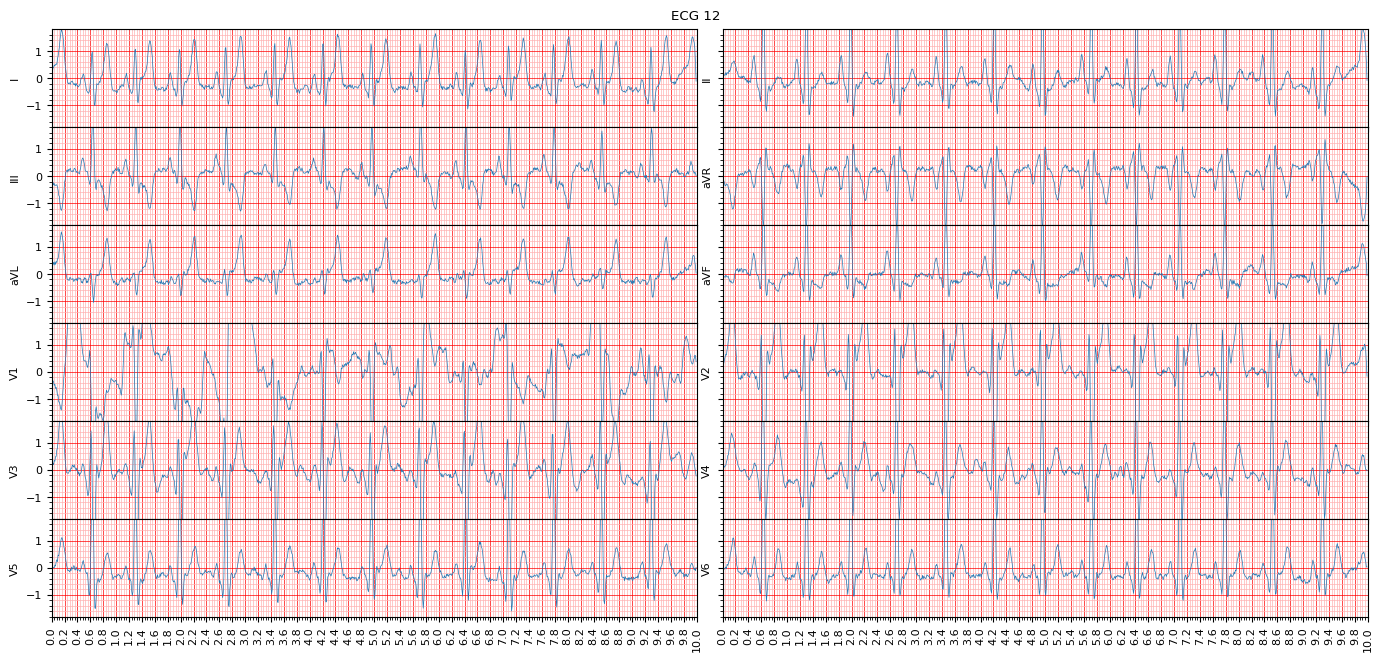

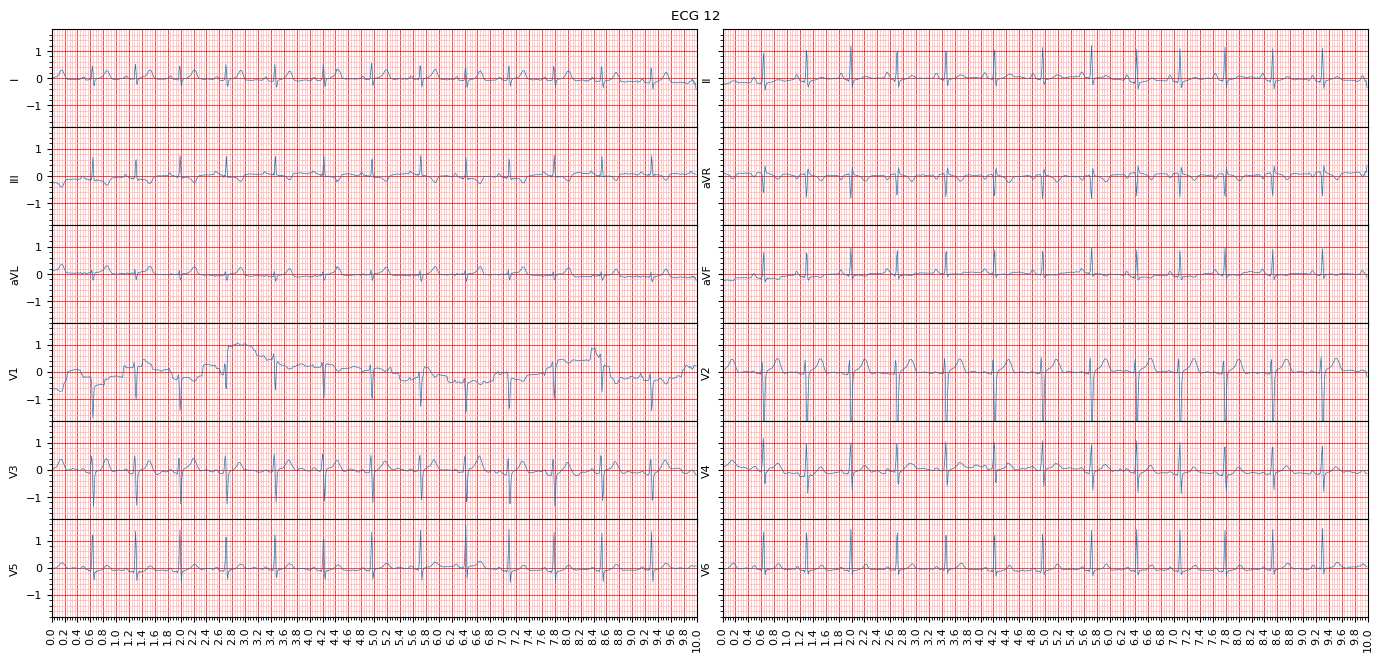

In [8]:
with tf.device('/CPU:0'):
    ecg_plot.plot_12(tf.transpose(X_final, (0,2,1))[5], sample_rate=100)
    ecg_plot.plot_12(tf.transpose(X, (0,2,1))[5], sample_rate=100)

### Splitting data in train, validation, testing data set

In [17]:

with tf.device('/CPU:0'):
    # Split data into train and test
    test_fold =10
    val_fold = 9

    def tvt_split(X, Y, val_fold, test_fold, shape = False):
        X_train = X[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)]
        y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)].age

        X_val = X[Y.strat_fold == val_fold]
        y_val = Y[Y.strat_fold == val_fold].age

        X_test = X[(Y.strat_fold == test_fold)]
        y_test = Y[Y.strat_fold == test_fold].age

        y_train = pd.get_dummies(y_train)
        y_val = pd.get_dummies(y_val)
        y_test = pd.get_dummies(y_test)

        y_train = y_train.idxmax(axis = 1).to_numpy()
        y_val = y_val.idxmax(axis = 1).to_numpy()
        y_test = y_test.idxmax(axis = 1).to_numpy()

        rX_train = X_train[(y_train < 89)] # Additional filtering of patients older than 89 and younger than 18
        ry_train = y_train[(y_train < 89)]

        rX_val = X_val[(y_val < 89)]
        ry_val = y_val[(y_val < 89)]

        rX_test = X_test[(y_test < 89)]
        ry_test = y_test[(y_test < 89)]

        if(shape == True):
            print((X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape))

        return rX_train, ry_train, rX_val, ry_val, rX_test, ry_test

    X_train, y_train, X_val, y_val, X_test, y_test = tvt_split(X_final, Y, val_fold, test_fold, True)

((17418, 1000, 12), (17418,), (2183, 1000, 12), (2183,), (2198, 1000, 12), (2198,))


### Data manipulation
* The date of birth only as age at the time of the ECG recording, where ages of more than 89 years appear in the range of 300 years in compliance with HIPAA standards as stated by the PTB-XL data page.

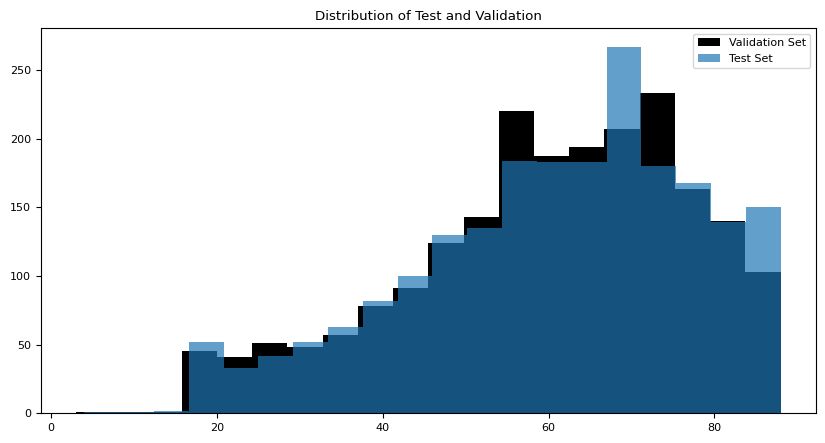

In [10]:
with tf.device('/CPU:0'):
    # Plotting the histograms
    plt.figure(figsize=(10,5))
    hist_val = plt.hist(y_val, label='Validation Set', color="black", bins = 20)
    hist_test = plt.hist(y_test, label='Test Set', alpha = 0.7, bins = 20)

    plt.legend()
    plt.title("Distribution of Test and Validation")

    plt.show()

### Distribution of Age
Non uniform distribution of data could contribute to bias in the classification model. It is apparent in the results of the model as it does a much better job at predicting ages within the range (60 to 75)

Text(0.5, 1.0, 'Distribution of Age')

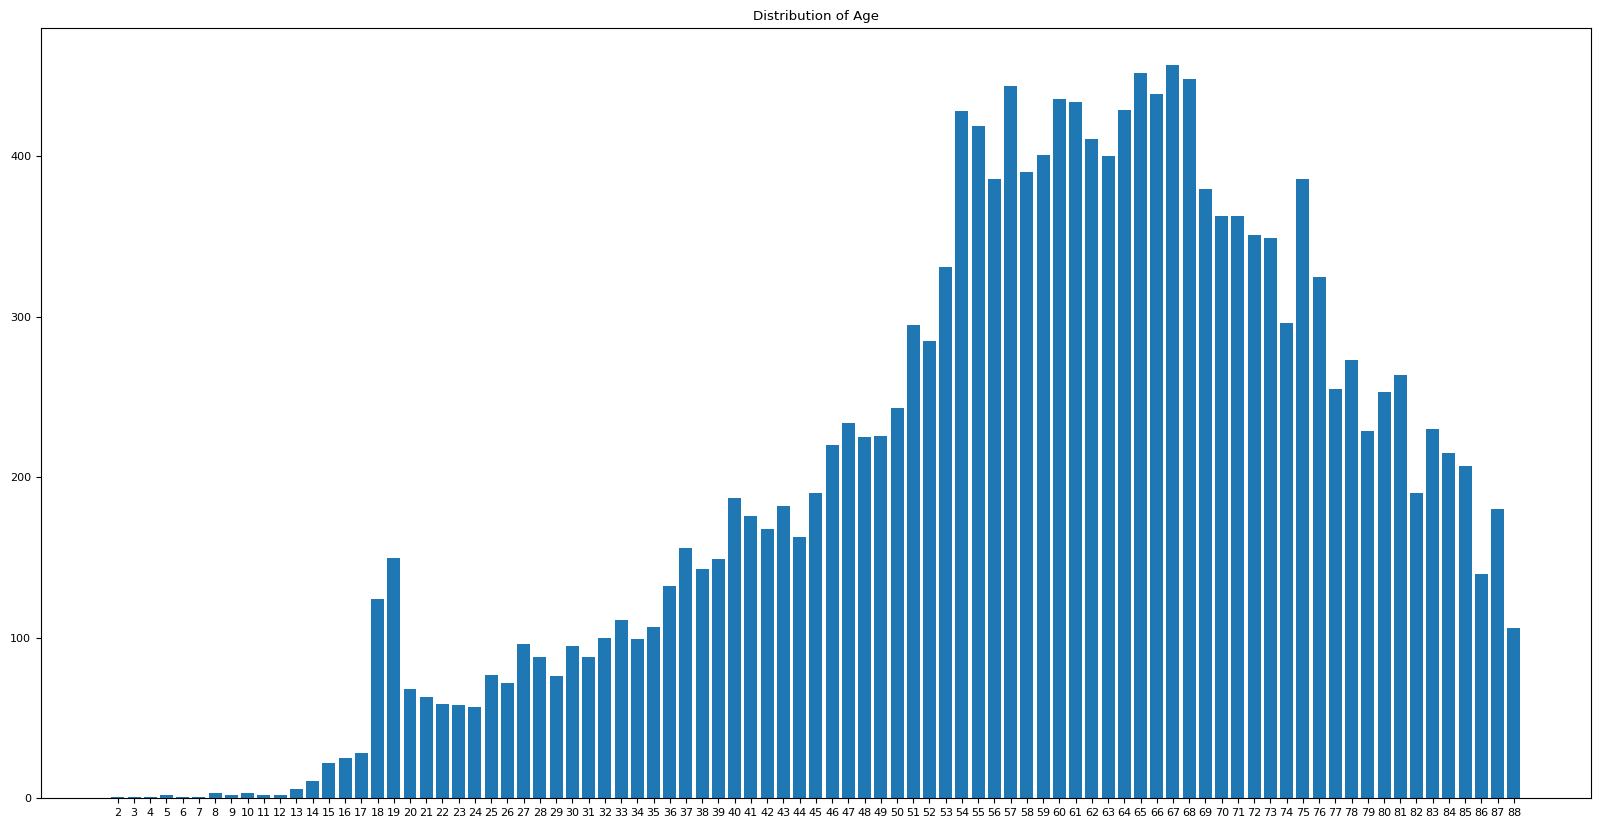

In [25]:
uniques, counts = np.unique(pd.DataFrame(y_train), return_counts=True)
plt.figure(figsize=(20,10))
plt.bar(uniques, counts)
plt.xticks(uniques, rotation = 0)
plt.title("Distribution of Age")

## Modelling

### Model 1
* If the model is too resource demanding, copy a smaller model from the age prediction models and adjust it to predict age. 
* ie. chnage the last layer from 'sigmoid' to 'linear'

In [18]:

tf.debugging.disable_traceback_filtering

# Batching
batch_size = 64   # Batch size determines the amount of data processed each round
num_epochs = 20   # All of the data is processed a certain number of time repetedly. Based on the number of epochs. 
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))   # Grouping the X and Y together. Similar to zipping

# Shuffle and batch the dataset
dataset = dataset.shuffle(buffer_size=len(X_train))   # We are able to shuffle both the X and Y the same because they are grouped. 
dataset = dataset.batch(batch_size)    # The input data is split into the batch size


# Creating the model
ecg_age_model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 16, kernel_size = 7, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 16, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 128, kernel_size = 12, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed = 13),


    tf.keras.layers.Dense(64, activation= 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(1, activation= 'linear')
])


# Compiling the model
ecg_age_model_1.compile(loss = tf.keras.losses.mse,
                    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0003),
                    metrics = ['mae'])


# Call Backs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (0.0008) * 10**(epoch/20))
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True)


# Train the model

ecg_age_model_1.fit(dataset, epochs = num_epochs, validation_data = (X_val, y_val))   # Performing data validation to verify model's performance on blind data.

Epoch 1/20
 25/268 [=>............................] - ETA: 3:36 - loss: 3693.7644 - mae: 58.7019

KeyboardInterrupt: 

In [ ]:
ecg_age_model_1.evaluate(X_test, y_test)  # Performs an evaluation on the testing data that may not be tuned to the hyperparameters. 
                                          # Final and most accurate evaluation of model's performance

67/67 [==============================] - 1s 10ms/step - loss: 137.1215 - mae: 9.3362


[137.12152099609375, 9.336234092712402]

## Performance Analysis

In [12]:
import seaborn as sns   # Remeber to install seaborn

# Predict on train
y_train_pred = ecg_age_model_1.predict(X_train)


# Create a DataFrame from the data
data = pd.DataFrame({'Category': np.squeeze(y_train), 'Values': np.squeeze(y_train_pred)})  # Merges the Actual and predicted data

# Create a group boxplot using seaborn
plt.figure(figsize=(30, 15))
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
sns.boxplot(x='Category', y='Values', data=data, width=0.6)   # Takes the unique values for X and plots them with all associated Y values. Thus a boxplot range is produced
category_positions = range(len(data['Category'].unique()))
plt.scatter(category_positions, np.unique(np.squeeze(y_test)), color='black', label='Scatter Plot', alpha = 0.7)   # The true line represents what the predicted age should be. 
plt.xlabel('Category')
plt.ylabel('Values')
plt.yticks(range(0, 110, 5)) 
plt.title('Evaluation of the Train set')
plt.show()

NameError: name 'ecg_age_model_1' is not defined

67/67 [==============================] - 1s 12ms/step


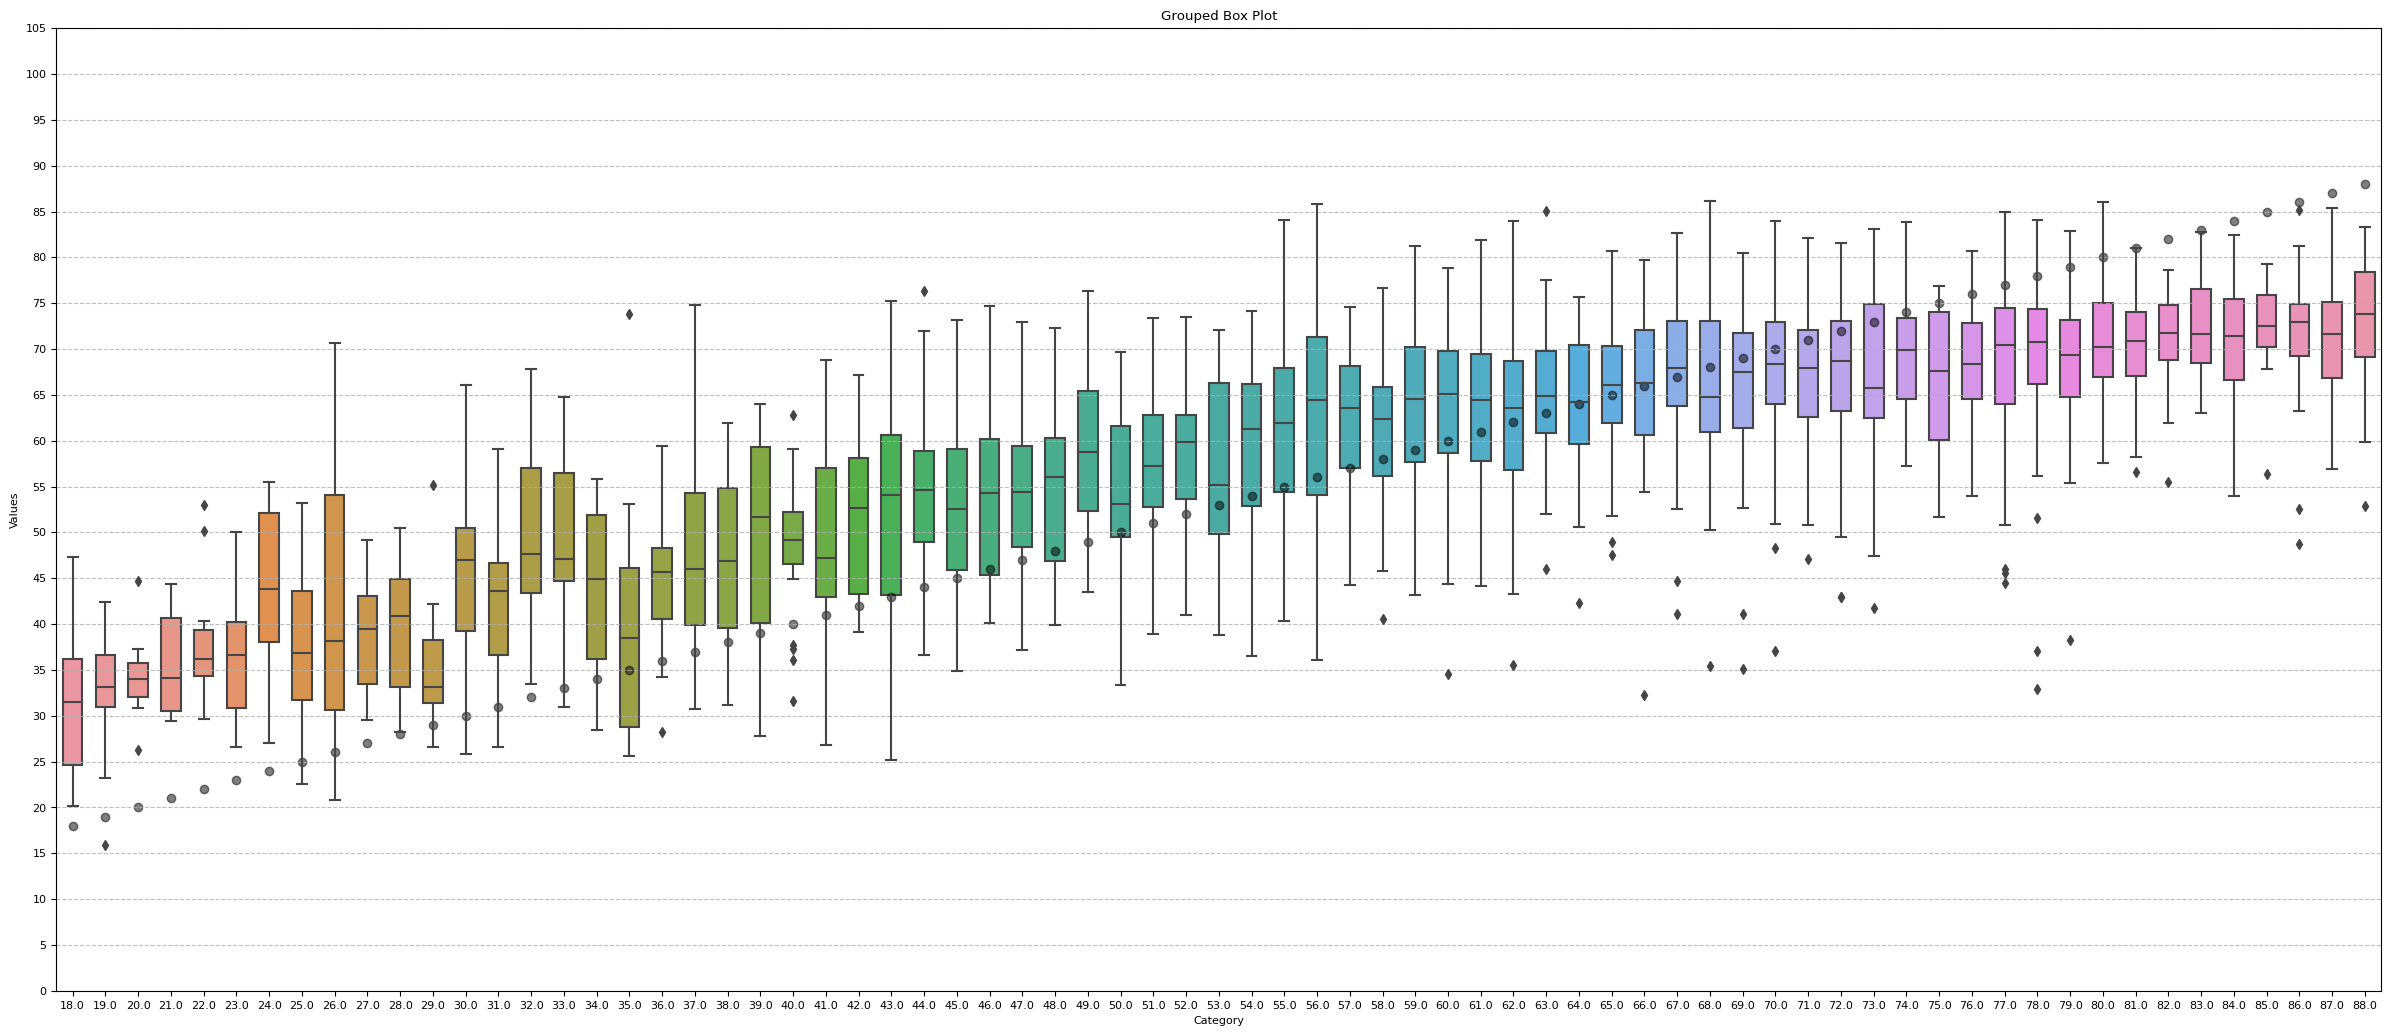

In [ ]:
# Predict on train
y_test_pred = ecg_age_model_1.predict(X_test)


# Create a DataFrame from the data
data = pd.DataFrame({'Category': np.squeeze(y_test), 'Values': np.squeeze(y_test_pred)})

# Create a group boxplot using seaborn
plt.figure(figsize=(30,12.5))
plt.grid(True, axis='both', linestyle='--', alpha=0.8)
sns.boxplot(x='Category', y='Values', data=data, width=0.6)

category_positions = range(len(data['Category'].unique()))
plt.scatter(category_positions, np.unique(np.squeeze(y_test)), color='black', label='Scatter Plot', alpha = 0.5)

#plt.scatter(np.unique(np.squeeze(y_test)), np.unique(np.squeeze(y_test)), color='red', label='Scatter Plot')

plt.xlabel('Category')
plt.ylabel('Values')
plt.yticks(range(0, 110, 5)) 
plt.title('Evaluation of the Test set')
plt.show()

### Further Data manipulation
We however do not recommend the use of time inversion, spatial inversion, permutation, and lead shuffling, whereas a careful design of all other basic DA techniques is needed. 

### <b>Random Resampling for Imbalanced Data Sets</b>
Our model show bias. Some age groups are under-represented while others are better-represented. The better represented age groups have a greater weight on the machine learning prediction model.
## Possible solutions for making imbalanced data sets Even:
Random Undersampling: delete examples from the majority class.

Random Oversampling: duplicate examples from the minority class.

Some issues with these methods in our scenario: Our data doesn't present age as a binary variable. Also, there are large discrepencies between each age. Since large discrepencies are so common, it's possible that undersampling and oversampling methods could lead to lower accuracy, especially if oversampling would mean duplicating a single value a hundred times with no randomization.

Possible solutions: Assign ages to two groups so we can present age as a binary variable. Or use a Multi-class Imbalanced Classification to keep each age as it's own "category."

Resources:

https://machinelearningmastery.com/multi-class-imbalanced-classification/

https://www.kaggle.com/code/rafjaa/resampling-strategies-for-imbalanced-datasets/notebook

Class=0, n=70 (32.710%)
Class=1, n=76 (35.514%)
Class=2, n=17 (7.944%)
Class=3, n=13 (6.075%)
Class=4, n=9 (4.206%)
Class=5, n=29 (13.551%)


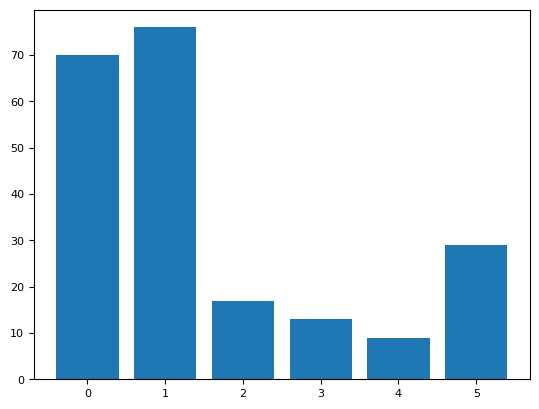

In [123]:
# Example of Imbalanced Data Set *NOT ECG DATA*
import imblearn
import io
import requests
# load and summarize the dataset
from pandas import read_csv
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
# define the dataset location
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/glass.csv"
s = requests.get(url).content
# load the csv file as a data frame
df = read_csv(io.StringIO(s.decode('utf-8')), header=None)
data = df.values
# split into input and output elements
X, y = data[:, :-1], data[:, -1]
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
 per = v / len(y) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

Class=0, n=76 (16.667%)
Class=1, n=76 (16.667%)
Class=2, n=76 (16.667%)
Class=3, n=76 (16.667%)
Class=4, n=76 (16.667%)
Class=5, n=76 (16.667%)


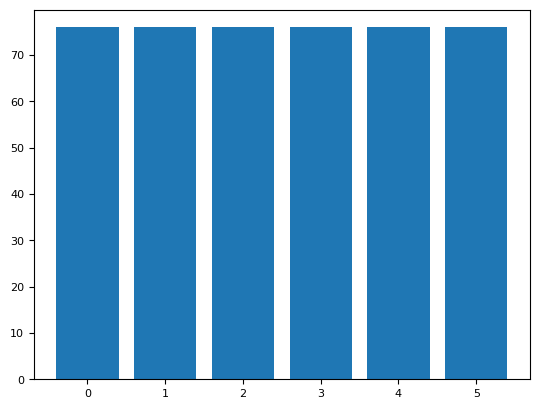

In [125]:
# Example of Imbalanced becoming Even by Oversampling a multi-class classification dataset *NOT ECG DATA*
from pandas import read_csv
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
# define the dataset location
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/glass.csv'
s = requests.get(url).content
# load the csv file as a data frame
df = read_csv(io.StringIO(s.decode('utf-8')), header=None)
data = df.values
# split into input and output elements
X, y = data[:, :-1], data[:, -1]
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
 per = v / len(y) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

Text(0.5, 1.0, 'Distribution of Age')

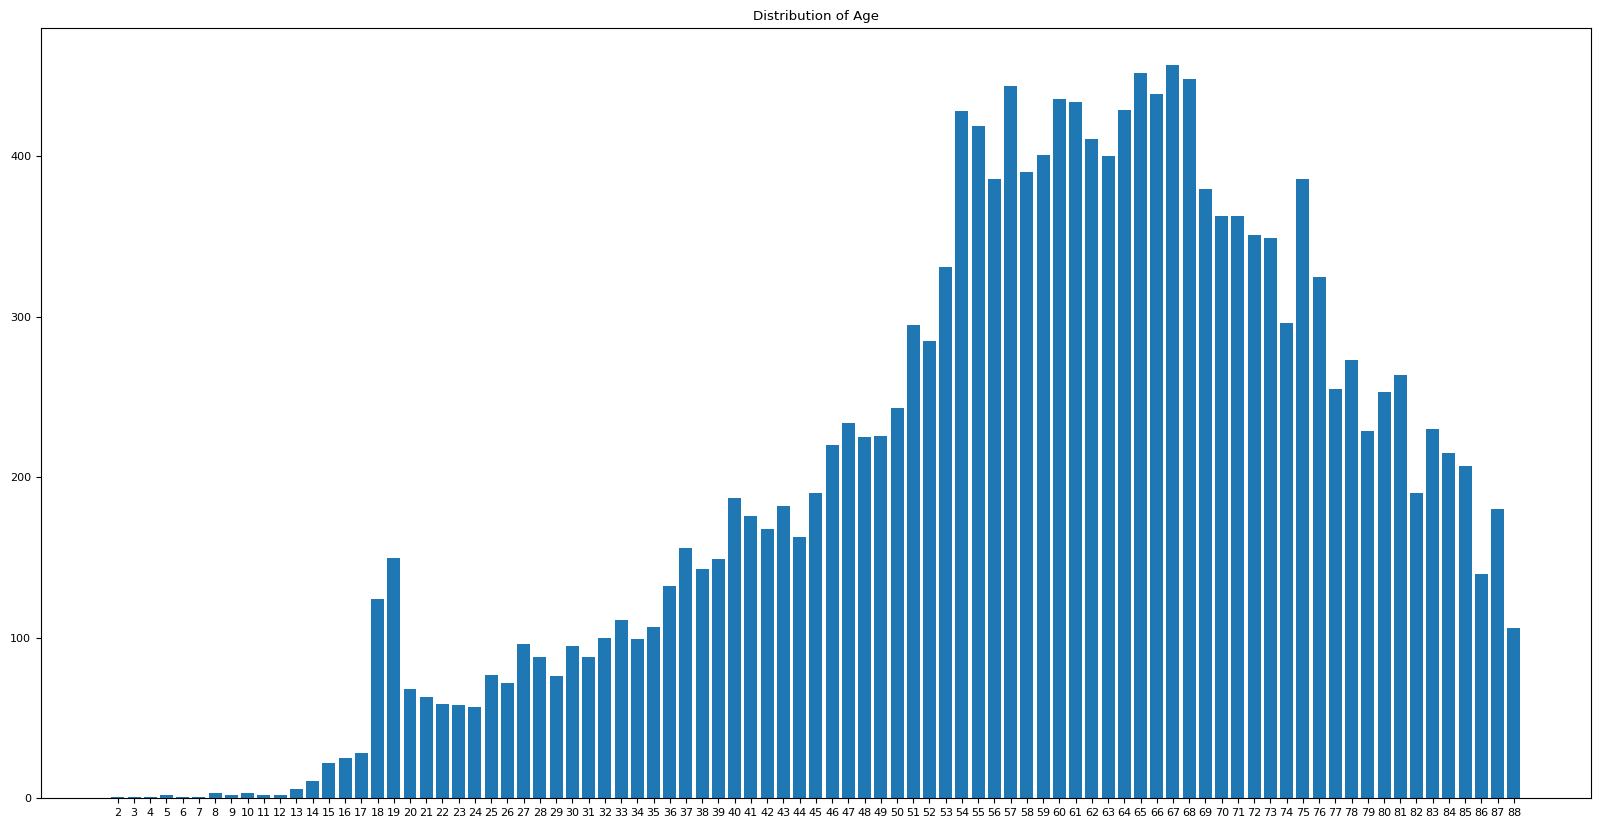

In [61]:
# Original Age Distribution Graph
uniques, counts = np.unique(pd.DataFrame(y_train), return_counts=True)
plt.figure(figsize=(20,10))
plt.bar(uniques, counts)
plt.xticks(uniques, rotation = 0)
plt.title("Distribution of Age")

In [127]:
# Trying to Resample Imbalanced with ECG Age Data
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder
uniques, counts = np.unique(pd.DataFrame(y_train), return_counts=True)

print(sum(counts))
print(len(counts))
average = round(sum(counts) / len(counts))
print(average)


oversample = SMOTE()
uniques, counts = oversample.fit_resample(uniques, counts)
# summarize distribution
# counter = Counter(y)
# for k,v in counter.items():
#  per = v / len(y) * 100
#  print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(uniques, counts)
pyplot.show()



# age_df = pd.DataFrame({'age': uniques, 'counts': counts}, columns=['age', 'counts'])
# age_data = age_df.values
# X, y = age_data[:, :-1], age_data[:, -1]

# print(age_df)
# print(age_data)

17133
87
197


ValueError: Expected 2D array, got 1D array instead:
array=[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55.
 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73.
 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.